In [1]:
import copy
import h5py
import itertools
import numpy as np
import os
import scipy
import scipy.interpolate
import tqdm

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import palettable

In [3]:
import yt
import trident
import unyt as u

In [4]:
import kalepy as kale
import verdict

In [5]:
import one_zone

# Parameters

In [6]:
# Analysis parameters
seed = 15482
rng = np.random.default_rng( seed )
verbose = False

In [7]:
# Data management parameters
distribution_fp = './data/EAGLE/histogram_galaxies_logM200c-Msun-12.0-12.5_200_seed0_hneutralssh.hdf5'
data_dir = './data/synthetic_data/sample1'
observer_data_dir = './data/synthetic_data_samples/sample1'

In [8]:
# Ray parameters
redshift = 0.25
n_sightlines = 100
min_clouds_per_sightline = 1
max_clouds_per_sightline = 3
velocity_range = [ -150., 150. ] # In km/s

In [9]:
# Spectra parameters
ions = [ 'H I', 'O I', 'C II', 'C III', 'N II', 'N III', 'Si II', 'Si III', 'Si IV', 'N V', 'O VI', ]
fields = [
    'H_p0_number_density', 
    'O_p0_number_density',
    'C_p1_number_density',
    'C_p2_number_density',
    'N_p1_number_density',
    'N_p2_number_density',
    'Si_p1_number_density',
    'Si_p2_number_density',
    'Si_p3_number_density',
    'N_p4_number_density',
    'O_p5_number_density',
]
snr = 30

# Load and Format Data

Units are [ g/cm^3, mass fraction, logK, log cm^-2 ] respectively for ['Density', 'Metallicity', 'Temperature', 'hneutralssh'].

In [10]:
f = h5py.File( distribution_fp, 'r' )

In [11]:
# Get centers, reformat edges

histogram_axes = [ 'Temperature', 'Density', 'Metallicity', 'hneutralssh' ]
centers = []
bins = []
dxs = []
for i, key in enumerate( histogram_axes ):
    
    arr = copy.copy( f['histogram_axes'][key][...] )
    dx = arr[2] - arr[1]
    
    # For convenience, let's not have a -inf edge lying around
    if key == 'Metallicity':
        arr[0] = arr[1] - dx
        
    centers_i = arr[:-1] + 0.5 * dx
    
    dxs.append( dx )
    centers.append( centers_i )
    bins.append( arr )

In [12]:
# Normalize into a pdf

norm = f['histogram'][...].sum() * dxs[0] * dxs[1] * dxs[2] * dxs[3]
pdf = f['histogram'][...] / norm

## Construct Ways to Sample the Distribution

In [13]:
# Create a Kernel Density Estimate to Allow Easy Resampling
kde = kale.KDE.from_hist(
    bins,
    pdf,
    reflect = [
        None,
        None,
        [ None, 0. ],
        None,
    ],
)

In [14]:
# Create an interpolation function
def prob_fn( temp, den, met, hi ):
    
    return scipy.interpolate.interpn( centers, pdf, [ temp, den, met, hi ] )[0]

In [15]:
# Find the peak
max_ind = np.argmax( pdf, )
max_inds = np.unravel_index( max_ind, f['histogram'][...].shape )
max_value = np.max( pdf )
p0 = tuple( [ centers[i][max_inds[i]] for i in range( len( max_inds ) ) ] )

In [16]:
# Check work
print( 'If these two values are consistent then interpolation is working correctly.' )
print( '    max value = {:.3g}, max interpolated value = {:.3g}'.format( max_value, prob_fn( *p0 ) ) )

If these two values are consistent then interpolation is working correctly.
    max value = 0.199, max interpolated value = 0.199


# Construct Sightline Parameters

## Construct

In [17]:
param_labels = [ 'Temperature', 'Density', 'Metallicity', 'HI Column' ]

In [18]:
sls = {
    'Temperature': [],
    'Density': [],
    'Metallicity': [],
    'HI Column': [],
    'LOS Velocity': [],
    'PDF Value': [],
}
for i in tqdm.tqdm( range( n_sightlines ) ):
    
    # Choose number of clouds
    n_clouds = rng.integers( min_clouds_per_sightline, max_clouds_per_sightline+1 )

    # Sample from distribution
    sample = kde.resample( n_clouds )

    # Store parameters
    for i, param in enumerate( param_labels ):
        sls[param].append( sample[i] )

    # Choose velocities
    sls['LOS Velocity'].append( rng.uniform( *velocity_range, size=n_clouds ) )
    
    # Identify frequency in simulations
    sls['PDF Value'].append( np.array([ prob_fn( *_ ) for _ in sample.transpose() ]) )

100%|██████████| 100/100 [00:16<00:00,  6.12it/s]


In [19]:
clouds = {}
for key, item in sls.items():
    clouds[key] = np.concatenate( item )

## Visualize

In [20]:
# Set up combinations to iterate through
inds = range( len( histogram_axes ) )
combinations = [ _ for _ in itertools.combinations( inds, 2 ) ]

<ipython-input-21-a1d574e5d047>:16: RuntimeWarning: divide by zero encountered in log10
  np.log10( projection ),


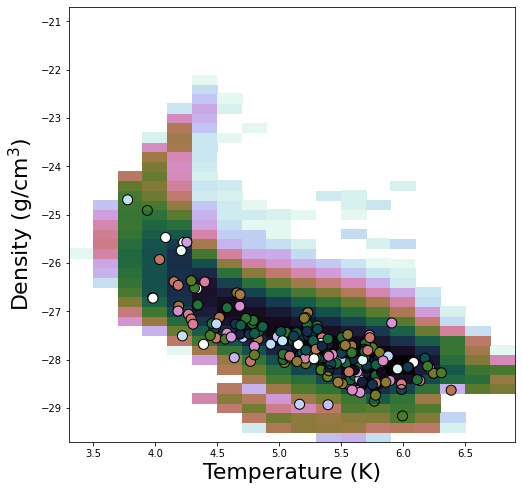

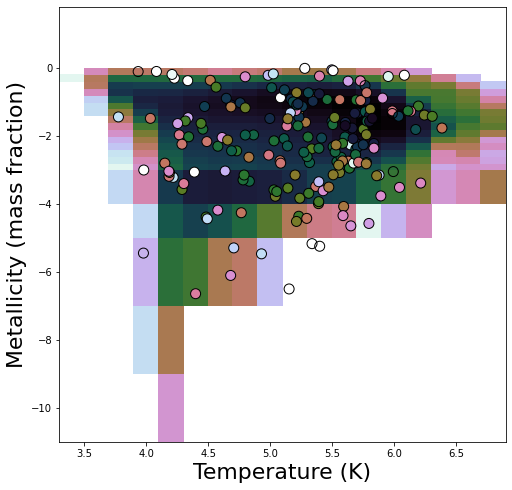

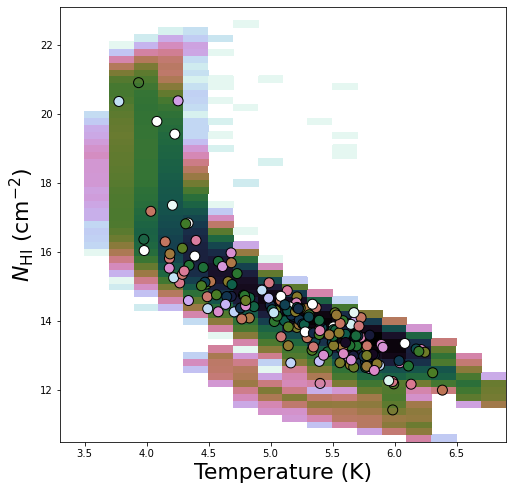

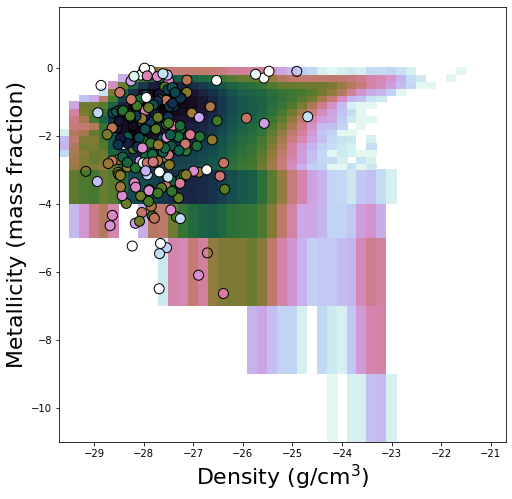

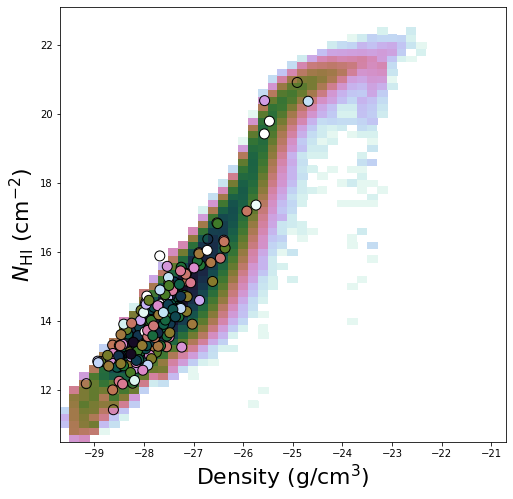

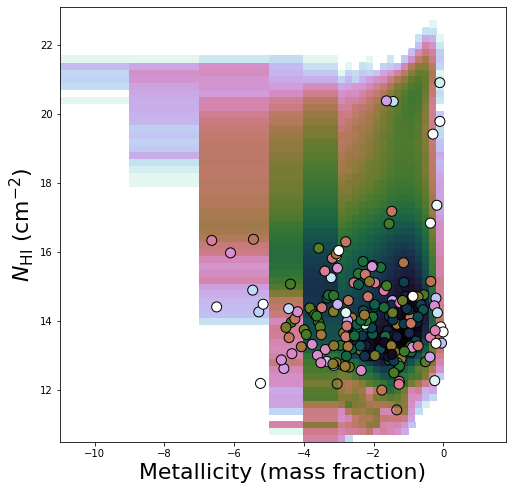

In [21]:
labels = [ 'Temperature (K)', r'Density (g/cm$^{3}$)', 'Metallicity (mass fraction)', r'$N_{\rm HI}$ (cm$^{-2}$)' ]
for k, (i, j) in enumerate( combinations ):
    
    # Show data
    fig = plt.figure( figsize=(8,8), facecolor='w' )
    ax = plt.gca()

    sum_axes = copy.copy( list( inds ) )
    sum_axes.remove( i )
    sum_axes.remove( j )
    projection = pdf.sum( axis=tuple( sum_axes ) ).transpose()
    x, y = np.meshgrid( centers[i], centers[j] )
    ax.pcolormesh(
        centers[i],
        centers[j],
        np.log10( projection ),
        cmap = 'cubehelix_r',
    )
    
    ax.scatter(
        clouds[param_labels[i]],
        clouds[param_labels[j]],
        edgecolor = 'k',
        s = 100,
        c = clouds['PDF Value'],
        vmin = np.nanmin( pdf[np.nonzero(pdf)] ),
        vmax = np.nanmax( pdf[np.nonzero(pdf)] ),
        cmap = palettable.cubehelix.classic_16_r.mpl_colormap,
        norm = matplotlib.colors.LogNorm(),
    )

    
    ax.set_xlabel( labels[i], fontsize=22 )
    ax.set_ylabel( labels[j], fontsize=22 )
    
    ax.set_aspect( 'auto' )
    
    plt.savefig(
        './figures/sample1/clouddist_{}_{}.png'.format(
            param_labels[i].replace( ' ', '' ),
            param_labels[j].replace( ' ', '' )
        ),
        bbox_inches = 'tight',
    )

# Create Spectra

Borrowing heavily from `one_zone.py`

In [22]:
# Objects for use
ldb = trident.LineDatabase('lines.txt')
sg_cos = trident.SpectrumGenerator('COS-G130M')

yt : [INFO     ] 2021-02-19 15:23:48,033 Setting instrument to COS-G130M


In [23]:
# Spectrum Generator for Mg II from ground
lambda_mg = ldb.select_lines( 'Mg', 'II' )[0].wavelength * ( 1. + redshift )
sg_mg = trident.SpectrumGenerator(
    lambda_min = lambda_mg - 15.,
    lambda_max = lambda_mg + 15.,
    dlambda = 0.01,
    lsf_kernel = os.path.join( trident.path, 'data', 'lsf_kernels', 'avg_COS.txt' ),
)

yt : [INFO     ] 2021-02-19 15:23:48,045 Setting instrument to Custom


In [24]:
def plot_ion( sg, element, ion_state, width=6. ):
    '''Save a plot of a particular part of the spectrum for inspection.'''
    
    lines = ldb.select_lines( element, ion_state )
    
    wavelengths = np.array([ _.wavelength for _ in lines ])
    adjusted_wavelengths = wavelengths * ( 1 + redshift )
    
    data_subdir = '{}/ion_spectra/{}{}'.format( data_dir, element, ion_state, )
    os.makedirs( data_subdir, exist_ok=True )
    for k, lambda_a in enumerate( adjusted_wavelengths ):
        if lambda_a - width/2. < sg.lambda_min or lambda_a + width/2 > sg.lambda_max:
            continue
            
        sg.plot_spectrum(
            '{}/spectrum_{:.1f}_sl{:04d}.png'.format( data_subdir, lambda_a, i ),
            lambda_limits = [ lambda_a - width/2, lambda_a + width/2 ]
        )

In [25]:
# Waaaay too much output otherwise
yt.utilities.logger.disable_stream_logging()

In [26]:
# Loop over and create all spectra
sls['Lengths'] = []
spectrum_sg_tags = [ '', '_MgII']
for i in tqdm.tqdm( range( n_sightlines ) ):
    
    for m, sg in enumerate( [ sg_cos, sg_mg ]):

        density = 10.**sls['Density'][i] * u.g * u.cm**-3
        temperature = 10.**sls['Temperature'][i] * u.K
        metallicity = 10.**sls['Metallicity'][i] * u.Zsun / 0.014
        HI_column = 10.**sls['HI Column'][i] * u.cm**-2
        velocity = sls['LOS Velocity'][i] * u.km / u.s

        spectrum_fps = [
            '{}/clouds/spectrum_sl{:04d}_cloud{:02d}.h5'.format( data_dir, i, j )
            for j in range( density.size )
        ]

        lengths_i = []
        taus_i = []
        for j, density_j in enumerate( density ):

            # First, let's create a one-zone dataset for our desired density,
            # temperature, metallicity, and redshift.  We'll arbitrarily set it to
            # be 1 kpc in width.  
            ds = trident.make_onezone_dataset(
                density = density[j],
                temperature = temperature[j],
                metallicity = metallicity[j],
                domain_width = 1.*u.kpc
            )
            ds.current_redshift = redshift

            # Now let's add our desired ions to this dataset, using Trident's 
            # lookup table based on the Haardt-Madau 2012 UV background.
            trident.add_ion_fields(ds, ions=ions)

            # Since we now know the HI number density for this dataset, and we
            # have a desired HI column density from the simulation distribution, we can divide 
            # these two to get a desired length for the dataset.
            length = HI_column[j] / ds.r[('gas', 'H_p0_number_density')][0]
            lengths_i.append( length )

            if verbose:
                print("DEBUG: For a log HI column of %s, we require a Pathlength of %s" % 
                        (np.log10(HI_column[i]), length.to('kpc')))

            if verbose:
                # Print out the dataset to STDOUT
                one_zone.print_dataset(ray, ions, fields)

            # Correct the redshift
            z_vel = np.sqrt( ( 1 + velocity[j] / u.c) / ( 1 - velocity[j] / u.c) ) - 1.
            z_cloud = ( 1. + redshift )*( 1. + z_vel ) - 1.

            # Now that we have a length for our dataset, which will produce our 
            # desired HI column density, let's generate a one-zone
            # LightRay (skewer) using this length, density, temperature, & redshift.
            # And add the relevant ions to this dataset.
            ray = trident.make_onezone_ray(
                density = density[j],
                temperature = temperature[j],
                metallicity = metallicity[j],
                length = length,
                redshift = z_cloud,
            )
            trident.add_ion_fields(ray, ions=ions)

            sg.make_spectrum( ray, lines=ions )
            sg.save_spectrum( spectrum_fps[j] )

            d = verdict.Dict.from_hdf5( spectrum_fps[j] )
            wavelength = d['wavelength']
            taus_i.append( d['tau'] )

        lengths_i = np.array( lengths_i )
        if m == 0:
            sls['Lengths'].append( lengths_i )
        taus_i = np.array( taus_i )

        # Combine into a new spectrum
        tau_i = np.sum( taus_i, axis=0 )
        flux_i = np.exp( -tau_i )
        sg.load_spectrum( wavelength * u.Angstrom, tau_i, flux_i )

        # Noise
        sg.apply_lsf()
        sg.add_gaussian_noise( snr )

        # Save
        sg.save_spectrum(
            '{}/spectrum{}_sl{:04d}.h5'.format( observer_data_dir, spectrum_sg_tags[m], i )
        )
        sg.plot_spectrum(
            '{}/spectrum{}_sl{:04d}.png'.format( observer_data_dir, spectrum_sg_tags[m], i )
        )

        # Plot individual ions for inspection
        if m == 0:
            for ion in ions:
                plot_ion( sg, *ion.split() )

100%|██████████| 100/100 [08:54<00:00,  5.35s/it]


## Save Sightline Input

Now that we also have the lengths of absorbers

In [28]:
sls = verdict.Dict( sls )
sls.to_hdf5( './data/synthetic_data/sample1/sightlines.h5', handle_jagged_arrs='row datasets', jagged_flag='sl' )